## Import libraries + set environments

In [ ]:
!pip install kagglehub --quiet

import kagglehub
import os, glob, re, json, cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import Conv2D, PReLU, Add
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
# Set precision policy for numerical stability
print('TensorFlow version:', tf.__version__)

try:
  from tensorflow.keras import mixed_precision
  mixed_precision.set_global_policy('float32')
  print('Using float32 policy')
except Exception as e:
  print('Mixed precision config skipped:', e)

AUTOTUNE = tf.data.AUTOTUNE

TensorFlow version: 2.19.0
Using float32 policy


## Download and load dataset

In [ ]:
path = kagglehub.dataset_download("takihasan/div2k-dataset-for-super-resolution")
print('Dataset base path:', path)

HR_TRAIN = os.path.join(path, "Dataset/DIV2K_train_HR")
LR4_TRAIN = os.path.join(path, "Dataset/DIV2K_train_LR_bicubic_X4/X4")
HR_VAL = os.path.join(path, "Dataset/DIV2K_valid_HR")
LR4_VAL = os.path.join(path, "Dataset/DIV2K_valid_LR_bicubic_X4/X4")

print('HR_TRAIN:', os.path.isdir(HR_TRAIN), len(glob.glob(HR_TRAIN+'/*.png')))
print('LR4_TRAIN:', os.path.isdir(LR4_TRAIN), len(glob.glob(LR4_TRAIN+'/*.png')))
print('HR_VAL:', os.path.isdir(HR_VAL), len(glob.glob(HR_VAL+'/*.png')))
print('LR4_VAL:', os.path.isdir(LR4_VAL), len(glob.glob(LR4_VAL+'/*.png')))

100%|██████████| 4.94G/4.94G [00:43<00:00, 122MB/s]

Extracting files...


Dataset base path: /root/.cache/kagglehub/datasets/takihasan/div2k-dataset-for-super-resolution/versions/1
HR_TRAIN: True 800
LR4_TRAIN: True 800
HR_VAL: True 100
LR4_VAL: True 100


In [ ]:
# Robust filename normalization to generate multiple matching keys for LR-HR pairing
def normalize_basename_for_matching(p):
  name = os.path.splitext(os.path.basename(p))[0]
  keys = set([name])
  keys.add(re.sub(r'[_\.\-]?[xX]\d+$', '', name))
  keys.add(re.sub(r'[xX]\d+$', '', name))
  keys.add(re.sub(r'[_\.\-]?(b|bicubic)?[xX]\d+$', '', name))
  m = re.search(r'(\d{1,6})', name)
  if m: keys.add(m.group(1))
  keys.add(re.sub(r'[^0-9a-zA-Z]+$', '', name))
  return keys

# Flexible LR-HR pairing mechanism that matches images using normalized keys with numeric-ID fallback
def paired_paths_flexible(lr_dir, hr_dir):
  lr_files = sorted(glob.glob(os.path.join(lr_dir, '*.png')))
  hr_files = sorted(glob.glob(os.path.join(hr_dir, '*.png')))

  hr_index = defaultdict(list)
  for p in hr_files:
    for k in normalize_basename_for_matching(p):
      hr_index[k].append(p)

  paired_lr, paired_hr = [], []
  for lr_p in lr_files:
    matched = False
    for k in normalize_basename_for_matching(lr_p):
      if k in hr_index:
        candidates = hr_index[k]
        exact = [c for c in candidates if os.path.splitext(os.path.basename(c))[0] == k]
        hr_p = exact[0] if exact else candidates[0]
        paired_lr.append(lr_p); paired_hr.append(hr_p)
        matched = True
        break
    if not matched:
      name_lr = os.path.splitext(os.path.basename(lr_p))[0]
      m = re.search(r'(\d{1,6})', name_lr)
      if m:
        num = m.group(1)
        for h in hr_files:
          if num in os.path.splitext(os.path.basename(h))[0]:
            paired_lr.append(lr_p); paired_hr.append(h)
            matched = True
            break
  return paired_lr, paired_hr

# Construct LR-HR training and validation pairs using the flexible matching system
train_lr_paths, train_hr_paths = paired_paths_flexible(LR4_TRAIN, HR_TRAIN)
val_lr_paths, val_hr_paths = paired_paths_flexible(LR4_VAL, HR_VAL)

# Display total pairs and sample LR-HR pairings
print('Train pairs:', len(train_lr_paths), 'Val pairs:', len(val_lr_paths))
for i in range(min(5, len(train_lr_paths))):
  print(os.path.basename(train_lr_paths[i]), '->', os.path.basename(train_hr_paths[i]))

Train pairs: 800 Val pairs: 100
0001x4.png -> 0001.png
0002x4.png -> 0002.png
0003x4.png -> 0003.png
0004x4.png -> 0004.png
0005x4.png -> 0005.png


## Preprocessing and prepares the training dataset pipeline

In [ ]:
SCALE = 4
PATCH_HR = 96
PATCH_LR = PATCH_HR // SCALE
BATCH = 4
print("PATCH LR:", PATCH_LR, "| PATCH HR:", PATCH_HR)

# Load LR-HR image pair and convert both images to float32 tensors in the [0, 1] range
def load_pair(lr_path, hr_path):
  lr = tf.io.read_file(lr_path)
  lr = tf.image.decode_png(lr, channels=3)
  lr = tf.image.convert_image_dtype(lr, tf.float32)

  hr = tf.io.read_file(hr_path)
  hr = tf.image.decode_png(hr, channels=3)
  hr = tf.image.convert_image_dtype(hr, tf.float32)
  return lr, hr

# Randomly sample a spatially aligned LR-HR patch pair with a safety resize step when the original image is smaller than the patch size
def random_crop_pair(lr, hr):
  h = tf.shape(lr)[0]
  w = tf.shape(lr)[1]

  def resize_safe():
    lr_r = tf.image.resize(lr, [PATCH_LR, PATCH_LR], method="bicubic")
    hr_r = tf.image.resize(hr, [PATCH_HR, PATCH_HR], method="bicubic")
    return lr_r, hr_r

  lr, hr = tf.cond(tf.logical_or(h<PATCH_LR, w<PATCH_LR), resize_safe, lambda: (lr,hr))

  h = tf.shape(lr)[0]
  w = tf.shape(lr)[1]

  rx = tf.random.uniform([], 0, h-PATCH_LR+1, dtype=tf.int32)
  ry = tf.random.uniform([], 0, w-PATCH_LR+1, dtype=tf.int32)

  lr_patch = lr[rx:rx+PATCH_LR, ry:ry+PATCH_LR, :]
  hr_patch = hr[rx*SCALE:rx*SCALE+PATCH_HR, ry*SCALE:ry*SCALE+PATCH_HR, :]

  return lr_patch, hr_patch

# Extract centered LR-HR patch pair, resizing images if they are smaller than the desired patch size
def center_crop_pair(lr, hr):
  h = tf.shape(lr)[0]
  w = tf.shape(lr)[1]

  def resize_safe():
    lr_r = tf.image.resize(lr, [PATCH_LR, PATCH_LR])
    hr_r = tf.image.resize(hr, [PATCH_HR, PATCH_HR])
    return lr_r, hr_r

  lr, hr = tf.cond(tf.logical_or(h<PATCH_LR, w<PATCH_LR), resize_safe, lambda: (lr,hr))

  h = tf.shape(lr)[0]
  w = tf.shape(lr)[1]
  cx = h//2 - PATCH_LR//2
  cy = w//2 - PATCH_LR//2

  lr_p = lr[cx:cx+PATCH_LR, cy:cy+PATCH_LR]
  hr_p = hr[cx*SCALE:cx*SCALE+PATCH_HR, cy*SCALE:cy*SCALE+PATCH_HR]
  return lr_p, hr_p

# Build a tf.data pipeline that loads LR-HR pairs, applies patch extraction, batch, and prefetch
def make_dataset(lr_paths, hr_paths, training=True):
  ds = tf.data.Dataset.from_tensor_slices((lr_paths, hr_paths))

  if training:
    ds = ds.shuffle(1000)

  def _load(l, h):
    lr, hr = tf.py_function(load_pair, [l, h], [tf.float32, tf.float32])
    lr.set_shape([None, None, 3])
    hr.set_shape([None, None, 3])
    return lr, hr

  ds = ds.map(_load, num_parallel_calls=AUTOTUNE)
  if training:
    ds = ds.map(random_crop_pair, num_parallel_calls=AUTOTUNE)
  else:
    ds = ds.map(center_crop_pair, num_parallel_calls=AUTOTUNE)

  ds = ds.batch(BATCH).prefetch(AUTOTUNE)
  return ds

train_ds = make_dataset(train_lr_paths, train_hr_paths, training=True)
val_ds = make_dataset(val_lr_paths, val_hr_paths, training=False)

# Set steps per epoch and val steps
steps_per_epoch = len(train_lr_paths) // BATCH
val_steps = len(val_lr_paths) // BATCH
print('steps_per_epoch:', steps_per_epoch, '| val_steps:', val_steps)

PATCH LR: 24 | PATCH HR: 96
steps_per_epoch: 200 | val_steps: 25


## SRRESNet generator model

In [ ]:
class PixelShuffleLayer(tf.keras.layers.Layer):
  def __init__(self, scale=2, **kwargs):
    super().__init__(**kwargs)
    self.scale = scale

  def call(self, x):
    return tf.nn.depth_to_space(x, self.scale)

def residual_block(x_in, filters=64):
  x = Conv2D(filters, 3, padding="same")(x_in)
  x = PReLU(shared_axes=[1,2])(x)
  x = Conv2D(filters, 3, padding="same")(x)
  return Add()([x_in, x])

def upsample_block(x, filters=64):
  # Conv2D to create r^2 channels
  x = Conv2D(filters * 4, 3, padding="same")(x)
  # Pixel shuffle using custom Keras-safe layer
  x = PixelShuffleLayer(scale=2)(x)
  x = PReLU(shared_axes=[1,2])(x)
  return x

# Build SRResNet generator model with dynamic spatial input size to support arbitrary-resolution inference
def build_srresnet(num_blocks=16, filters=64, scale=4):
  # Use dynamic height and width (None, None) so the model can infer on images of arbitrary spatial resolution
  inp = Input((None, None, 3))

  x = Conv2D(filters, 9, padding="same")(inp)
  x = PReLU(shared_axes=[1,2])(x)
  x1 = x

  for _ in range(num_blocks):
    x = residual_block(x, filters)

  x = Conv2D(filters, 3, padding="same")(x)
  x = Add()([x, x1])

  for _ in range(int(np.log2(scale))):
    x = upsample_block(x, filters)

  # Output layer (RGB, normalized to [0,1])
  out = Conv2D(3, 9, padding="same", activation="sigmoid")(x)
  return Model(inp, out, name="SRResNet")

model = build_srresnet()
model.summary()

Model: "SRResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │     15,616 │ input_layer[0][0] │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, None,      │         64 │ conv2d[0][0]      │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │     36,928 │ p_re_lu[0][0]     │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, None,      │         64 │ conv2d_1[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     36,928 │ p_re_lu_1[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None,      │          0 │ p_re_lu[0][0],    │
│                     │ None, 64)         │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │     36,928 │ add[0][0]         │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, None,      │         64 │ conv2d_3[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │     36,928 │ p_re_lu_2[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, None,      │          0 │ add[0][0],        │
│                     │ None, 64)         │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, None,      │     36,928 │ add_1[0][0]       │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_3 (PReLU)   │ (None, None,      │         64 │ conv2d_5[0][0]    │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, None,      │     36,928 │ p_re_lu_3[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, None,      │          0 │ add_1[0][0],      │
│                     │ None, 64)         │            │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, None,      │     36,928 │ add_2[0][0]       │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_4 (PReLU)   │ (None, None,      │         64 │ conv2d_7[0][0]  

 Total params: 1,546,435 (5.90 MB)

 Trainable params: 1,546,435 (5.90 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [ ]:
# Training using mae loss
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="mae",
    metrics=["mae"]
)

# Callbacks for saving checkpoint
ckpt = ModelCheckpoint(
    "/content/srresnet_best.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

# Learning rate scheduler
lr_sched = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=10,
    verbose=1
)

EPOCHS = 200

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[ckpt, lr_sched]
)

Epoch 1/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 107s 368ms/step - loss: 0.1956 - mae: 0.1956 - val_loss: 0.1023 - val_mae: 0.1023 - learning_rate: 1.0000e-04
Epoch 2/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 68s 337ms/step - loss: 0.0929 - mae: 0.0929 - val_loss: 0.0819 - val_mae: 0.0819 - learning_rate: 1.0000e-04
Epoch 3/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 78s 319ms/step - loss: 0.0763 - mae: 0.0763 - val_loss: 0.0808 - val_mae: 0.0808 - learning_rate: 1.0000e-04
Epoch 4/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 324ms/step - loss: 0.0649 - mae: 0.0649 - val_loss: 0.0802 - val_mae: 0.0802 - learning_rate: 1.0000e-04
Epoch 5/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 64s 319ms/step - loss: 0.0650 - mae: 0.0650 - val_loss: 0.0751 - val_mae: 0.0751 - learning_rate: 1.0000e-04
Epoch 6/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 64s 319ms/step - loss: 0.0598 - mae: 0.0598 - val_loss: 0.0713 - val_mae: 0.0713 - learning_rate: 1.0000e-04
Epoch 7/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 64s 317ms/step - loss: 0.0605 - mae: 0.0605 - val_loss: 0.

In [ ]:
# Save model
model.save("/content/srresnet_final.keras")
print("Model saved to /content/srresnet_final.keras")

Model saved to /content/srresnet_final.keras


## Visualize LR, SR, and HR using sample from the validation set

LR: 510×339
SR: 2040×1356
HR: 2040×1356


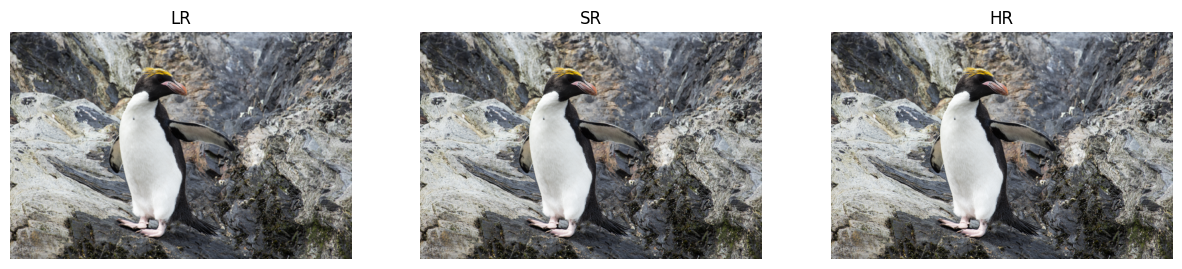

In [ ]:
# Return string of image resolution
def _res_str(img):
  h, w = img.shape[:2]
  return f"{w}×{h}"

# Run super-resolution inference on a single LR image
def upscale_image(path, model, save_to=None):
  # Load LR image
  img = Image.open(path).convert("RGB")
  lr  = np.array(img).astype("float32") / 255.0

  # Generate super-resolved output
  sr = model.predict(lr[None, ...], verbose=0)[0]
  sr = np.clip(sr, 0, 1)

  # Convert to uint8
  sr_img = (sr*255).astype("uint8")
  if save_to:
    Image.fromarray(sr_img).save(save_to)

  return lr, sr

# Visualization using one sample from the validation set
if len(val_lr_paths) > 0:
  lr_path = val_lr_paths[0]
  hr_path = val_hr_paths[0]

  lr = tf.image.convert_image_dtype(
      tf.io.decode_png(tf.io.read_file(lr_path), channels=3), tf.float32
  ).numpy()

  hr = tf.image.convert_image_dtype(
      tf.io.decode_png(tf.io.read_file(hr_path), channels=3), tf.float32
  ).numpy()

  sr = model.predict(lr[None,...], verbose=0)[0]

  # Display visualization
  print("LR:", _res_str(lr))
  print("SR:", _res_str(sr))
  print("HR:", _res_str(hr))

  plt.figure(figsize=(15,5))
  plt.subplot(1,3,1); plt.imshow(lr); plt.title("LR"); plt.axis("off")
  plt.subplot(1,3,2); plt.imshow(sr); plt.title("SR"); plt.axis("off")
  plt.subplot(1,3,3); plt.imshow(hr); plt.title("HR"); plt.axis("off")
  plt.show()

## Test model for uploaded low-resolution images

SRResNet Inference model loaded: /content/srresnet_final.keras

Please upload LR image to be upscaled:


Saving 0823x2.png to 0823x2.png

Uploaded file: 0823x2.png

Super Resolution Results
Input  (LR) : 0823x2.png | resolution = 1020×642
Output (SR) : /content/srresnet_output.png | resolution = 4080×2568


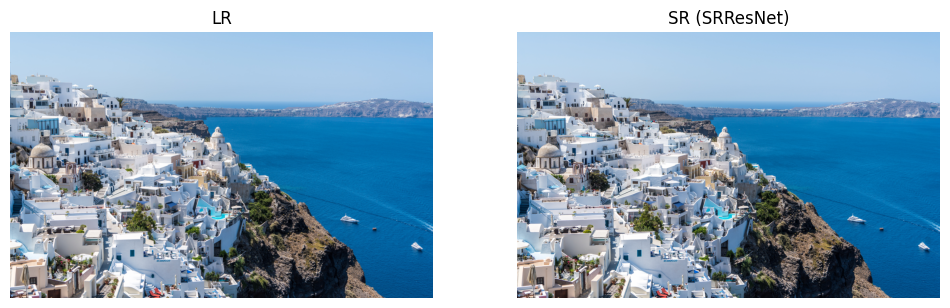

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Import libraries
from tensorflow.keras.models import load_model
from google.colab import files
import io

# Load model
INFER_MODEL_PATH = "/content/srresnet_final.keras"

gen_infer = load_model(
    INFER_MODEL_PATH,
    custom_objects={"PixelShuffleLayer": PixelShuffleLayer},
    compile=False
)

print("SRResNet Inference model loaded:", INFER_MODEL_PATH)

# Upload LR image that will be upscaled
print("\nPlease upload LR image to be upscaled:")
uploaded = files.upload()

input_path = list(uploaded.keys())[0]
print(f"\nUploaded file: {input_path}")

output_path = "/content/srresnet_output.png"

lr_img, sr_img = upscale_image(input_path, gen_infer, save_to=output_path)

print("\nSuper Resolution Results")
print(f"Input  (LR) : {input_path} | resolution = {_res_str(lr_img)}")
print(f"Output (SR) : {output_path} | resolution = {_res_str(sr_img)}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(lr_img); plt.title("LR"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(sr_img); plt.title("SR (SRResNet)"); plt.axis("off")
plt.show()

files.download(output_path)